# Held-out log-likelihood

In [6]:
import numpy as np
import matplotlib.pyplot as plt

## T-dSB-DP versus N-dSB-DP across mini-batch iterations

In [7]:
def varyK_NvsT(Klist, T, D, inroot, heldoutroot, expset, ax):
    """
    Inputs:
        Klist: list of approximation levels
        T: scalar, per-document cap on number of topics
        D: scalar, mini-batch size 
        expset: list of experimental seeds
        ax: axis to plot
    Outputs:
        plots LL of T-dSB-DP and N-dSB-DP versus number of minibatches
    Remarks: 
        all experiments are expected to run until completion i.e. 
        the same number of iterations.
    """
    nhdp = {}
    nhdp['avg'] = []
    nhdp['err'] = []
    thdp = {}
    thdp['avg'] = []
    thdp['err'] = []
    for i in range(len(Klist)):
        K = Klist[i]
        
        # average held-out log-likelihood at convergence of N-dSB-DP
        nhdpdir = "results/nhdpK" + str(K) + "_T" + str(T) + "_" + "D" + str(D) + "_" + inroot + "_" + heldoutroot
        finalnhdpLL = []
        ## load experiments
        for seed in expset:
            nhdppath = nhdpdir + "/LL_" + str(seed) + ".csv"
            result = np.loadtxt(nhdppath)
            # extract only LL at convergence
            finalnhdpLL.append(result[-1,2])
        finalnhdpLL = np.array(finalnhdpLL) # shape (len(expset),)
        nhdp['avg'].append(np.mean(finalnhdpLL)) # scalar
        nhdp['err'].append(np.std(finalnhdpLL)) # scalar
    
        # average held-out log-likelihood at convergence of T-dSB-DP
        thdpdir = "results/thdpK" + str(K) + "_T" + str(T) + "_" + "D" + str(D) + "_" + inroot + "_" + heldoutroot
        finalthdpLL = []
        ## load experiments
        for seed in expset:
            thdppath = thdpdir + "/LL_" + str(seed) + ".csv"
            result = np.loadtxt(thdppath)
            # extract only LL at convergence 
            finalthdpLL.append(result[-1,2])
        finalthdpLL = np.array(finalthdpLL) # shape (len(expset),)
        thdp['avg'].append(np.mean(finalthdpLL)) # scalar
        thdp['err'].append(np.std(finalthdpLL)) # scalar
        
    ax.errorbar(Klist, nhdp['avg'], yerr=nhdp['err'],label='N-dSB-DP')
    ax.errorbar(Klist, thdp['avg'], yerr=thdp['err'],label='T-dSB-DP')
    
    ax.set_title('D = %d, T = %d' %(D,T))
    ax.set_xlabel('K')
    ax.set_ylabel('Held-out log-likelihood at convergence')
    ax.legend()
    
    return 

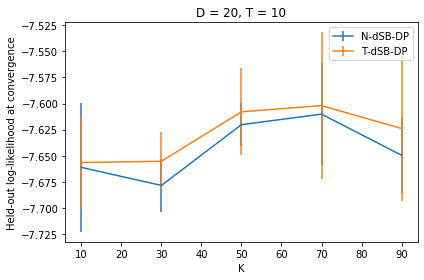

In [9]:
Klist = [10, 30, 50, 70, 90]
Dlist = [20, 50, 100]
T = 10


plt.figure()
varyK_NvsT(Klist, T, Dlist[0], "wiki10k","wiki1k", range(0,5), plt.gca())

"""
fig, axes = plt.subplots(1,3,figsize=(12,4))

for i in range(3):
    varyK_NvsT(Klist, T, Dlist[i], "wiki10k","wiki1k", range(0,5), axes[i])
"""

plt.tight_layout()
plt.show()

# Inferred topics

In [63]:
import numpy as np
import pandas as pd

In [72]:
from utils import GEM_expectation
import matplotlib.pyplot as plt

def printtopics(vocabfile, file, method, dirthresh, probthresh, displaycount):
    """
    Inputs:
        vocabfile:
        file:
        method:
        dirthresh:
        probthresh:
        displaycount:
    Outputs:
    """
    vocab = open(vocabfile).readlines()
    testlambda = np.loadtxt(file["lambda"])
    # compute expectation of topic's underlying probability
    testa = np.loadtxt(file["a"])
    if (method == "thdp"):
        testb = np.loadtxt(file["b"]) 
        probs = GEM_expectation(testa[np.newaxis,:],testb[np.newaxis,:]).flatten()
    elif (method == "nhdp"):
        probs = testa/np.sum(testa)
        
    # sort topics first by probs
    idx = [i for i in reversed(np.argsort(probs))]
    probs = probs[idx]
    testlambda = testlambda[idx, :]
        
    # how many topics explain most of the data?
    cumsum = np.cumsum(probs)
    for i in range(0, len(testlambda)):
        if (cumsum[i]>probthresh):
            lastidx = i
            break
    
    # plot the expectations
    plt.figure()
    plt.plot(probs, marker='o', markersize=4, label='Expected proportions',color='b')
    plt.axvline(x=lastidx,label='Last explanatory topic',color='r', linestyle='--')
    plt.title("Expected underlying proportions. \n Explanatory threshold %.2f" %probthresh)
    plt.xlabel("Topic index")
    plt.ylabel("Underlying proportions")
    plt.legend()
    plt.show()
    
    sigtopics = 0
    df = pd.DataFrame() 
    for k in range(0, len(testlambda)):
        lambdak = list(testlambda[k, :])
        lambdak = [round(i,1) for i in lambdak]
        temp = list(zip(lambdak, list(range(0, len(lambdak)))))
        temp = sorted(temp, key = lambda x: x[0], reverse=True)
        dirichlets = np.array(temp)[:,0]
        widices = np.array(temp,dtype=int)[:,1]
        # plot topics with parameters exceeding the threshold
        if (dirichlets[0] >= dirthresh):
            meanparam = np.mean(dirichlets[:displaycount])
            colname = "%d: prob %.2f, mean %.2f" % (k, probs[k], meanparam)
            coldata = [(str.strip(vocab[widices[i]]), dirichlets[i]) for i in range(0, displaycount)]
            df[colname] = coldata
    print("Discovered %d significant topics at dirichlet threshold %.2f" %(len(df.columns),threshold))
    return df

### T_HDP output with no topic ordering 

In [21]:
vocabfile = "dictnostops.txt"
file = {}
file["lambda"] ="results/thdpK100_D50_wiki10k_wiki1k/lambda-400.dat"
file["a"] ="results/thdpK100_D50_wiki10k_wiki1k/a-400.dat"
file["b"] ="results/thdpK100_D50_wiki10k_wiki1k/b-400.dat"
normalized = False
method = "thdp"
threshold = 50
displaycount = 10
df = printtopics(vocabfile, file, method, normalized, threshold, displaycount)
df

Discovered 5 significant topics at threshold 50.00


,topic 35: prob 0.00,topic 84: prob 0.00,topic 87: prob 0.01,topic 98: prob 0.03,topic 99: prob 0.97
0,"(draw, 326.5)","(italy, 130.2)","(district, 759.2)","(species, 1197.5)","(score, 10527.4)"
1,"(hard, 125.9)","(architecture, 99.7)","(county, 480.4)","(line, 1046.6)","(new, 10447.6)"
2,"(clay, 125.3)","(design, 85.9)","(population, 466.1)","(two, 1014.5)","(first, 9964.7)"
3,"(draws, 110.6)","(competition, 63.6)","(village, 424.7)","(system, 851.5)","(team, 8906.8)"
4,"(anna, 72.2)","(magazine, 55.4)","(province, 387.9)","(station, 780.5)","(two, 6475.3)"
5,"(julia, 48.6)","(new, 43.8)","(rural, 337.2)","(new, 747.3)","(years, 5901.0)"
6,"(laura, 36.0)","(venice, 41.6)","(central, 195.3)","(first, 723.1)","(time, 5469.1)"
7,"(united, 34.4)","(art, 33.2)","(poland, 155.5)","(found, 678.2)","(school, 5318.1)"
8,"(mas, 30.0)","(international, 30.4)","(elevation, 145.3)","(high, 659.5)","(march, 5196.0)"
9,"(states, 29.6)","(national, 30.3)","(districts, 137.2)","(time, 657.2)","(year, 5140.9)"


### T_HDP with topic ordering but slightly incorrect E-step due to expect_log_sticks

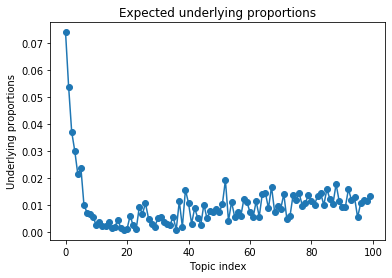

Discovered 28 significant topics at threshold 200.00


,topic 0: prob 0.07,topic 1: prob 0.05,topic 2: prob 0.04,topic 3: prob 0.03,topic 4: prob 0.02,topic 5: prob 0.02,topic 6: prob 0.01,topic 7: prob 0.01,topic 8: prob 0.01,topic 9: prob 0.01,...,topic 25: prob 0.01,topic 31: prob 0.01,topic 38: prob 0.00,topic 42: prob 0.01,topic 49: prob 0.01,topic 77: prob 0.01,topic 87: prob 0.01,topic 88: prob 0.02,topic 90: prob 0.01,topic 94: prob 0.01
0,"(new, 4132.3)","(new, 1773.2)","(new, 1842.6)","(march, 4068.0)","(new, 1002.8)","(goals, 1936.0)","(john, 1851.3)","(score, 8036.1)","(team, 1292.5)","(ship, 930.4)",...,"(species, 220.4)","(major, 230.4)","(air, 313.5)","(fat, 654.2)","(sign, 221.7)","(neat, 207.5)","(town, 463.0)","(week, 828.9)","(max, 222.4)","(alexander, 234.2)"
1,"(first, 2604.4)","(two, 1354.7)","(first, 1413.6)","(gen, 2412.6)","(school, 826.7)","(years, 1768.9)","(lord, 1488.3)","(team, 4216.4)","(round, 914.7)","(station, 393.7)",...,"(family, 94.4)","(nest, 76.3)","(squadron, 237.0)","(studio, 73.1)","(horn, 62.3)","(data, 47.4)","(county, 348.8)","(color, 398.2)","(louise, 80.5)","(books, 41.3)"
2,"(school, 2005.4)","(best, 1020.4)","(university, 1140.8)","(regiment, 2144.1)","(power, 800.0)","(team, 1469.7)","(william, 1155.2)","(goals, 2015.8)","(first, 647.5)","(line, 230.7)",...,"(snake, 93.5)","(first, 44.1)","(base, 93.0)","(first, 36.3)","(power, 42.1)","(aux, 31.4)","(meeting, 145.1)","(match, 57.0)","(sign, 60.6)","(major, 38.9)"
3,"(city, 1665.2)","(time, 1018.3)","(american, 1022.5)","(colonel, 1866.3)","(first, 773.4)","(first, 1440.7)","(sir, 922.8)","(seed, 1544.2)","(season, 643.0)","(ships, 161.4)",...,"(described, 88.5)","(oak, 40.7)","(force, 91.4)","(music, 30.1)","(trail, 31.6)","(faces, 28.5)","(council, 84.7)","(mens, 45.6)","(deaf, 37.9)","(facts, 38.4)"
4,"(two, 1630.5)","(music, 988.0)","(two, 850.3)","(september, 1739.1)","(area, 752.2)","(season, 1374.6)","(henry, 840.2)","(attendance, 1151.8)","(score, 550.5)","(service, 153.4)",...,"(found, 84.8)","(species, 35.2)","(operations, 71.4)","(day, 29.6)","(texas, 30.3)","(mars, 27.4)","(region, 84.2)","(san, 38.5)","(color, 25.5)","(des, 33.9)"
5,"(york, 1460.3)","(song, 864.9)","(law, 831.8)","(october, 1715.7)","(state, 688.2)","(clubs, 1288.5)","(george, 817.9)","(report, 1078.7)","(mens, 483.5)","(railway, 144.5)",...,"(genus, 79.4)","(workers, 32.9)","(group, 57.7)","(mud, 25.6)","(speaker, 25.1)","(refuge, 27.0)","(bridge, 78.9)","(world, 31.1)","(new, 23.0)","(scottish, 33.4)"
6,"(state, 1449.0)","(live, 829.5)","(states, 814.2)","(new, 1538.0)","(population, 682.3)","(club, 1201.5)","(general, 799.8)","(result, 906.5)","(seed, 474.2)","(war, 131.0)",...,"(australia, 74.3)","(food, 32.7)","(defense, 48.9)","(book, 17.7)","(increase, 24.4)","(als, 26.6)","(new, 76.9)","(california, 27.2)","(opera, 21.9)","(work, 31.4)"
7,"(time, 1447.1)","(japan, 827.4)","(school, 789.7)","(first, 1527.2)","(high, 668.8)","(league, 1152.9)","(charles, 787.1)","(yard, 672.5)","(won, 467.3)","(glory, 120.7)",...,"(black, 64.2)","(meaning, 31.4)","(combat, 36.0)","(asks, 16.1)","(game, 23.5)","(research, 22.8)","(river, 57.2)","(state, 26.9)","(secret, 19.4)","(american, 31.4)"
8,"(road, 1427.4)","(work, 813.0)","(state, 783.6)","(april, 1499.0)","(two, 610.6)","(new, 956.5)","(february, 551.2)","(points, 500.9)","(final, 425.4)","(border, 117.3)",...,"(brown, 50.2)","(three, 30.1)","(july, 34.6)","(mexican, 14.7)","(governor, 23.1)","(var, 22.5)","(mayor, 50.4)","(davis, 25.1)","(mine, 17.9)","(jean, 27.0)"
9,"(american, 1367.0)","(three, 810.8)","(jewish, 746.0)","(value, 1490.3)","(city, 601.0)","(career, 824.2)","(july, 533.7)","(round, 395.0)","(event, 419.7)","(fleet, 115.4)",...,"(head, 37.7)","(prey, 27.6)","(august, 34.0)","(mad, 14.3)","(forward, 22.6)","(day, 21.1)","(south, 39.0)","(place, 17.8)","(site, 16.7)","(france, 26.1)"


In [37]:
vocabfile = "dictnostops.txt"
file = {}
file["lambda"] ="results/thdpK100_D20_wiki10k_wiki1k/lambda-400.dat"
file["a"] ="results/thdpK100_D20_wiki10k_wiki1k/a-400.dat"
file["b"] ="results/thdpK100_D20_wiki10k_wiki1k/b-400.dat"
normalized = False
method = "thdp"
threshold = 200
displaycount = 10
df = printtopics(vocabfile, file, method, normalized, threshold, displaycount)
df

### T_HDP with topic ordering, slightly incorrect E-step due to expect_log_sticks, ran for almost 1000 mini-batches

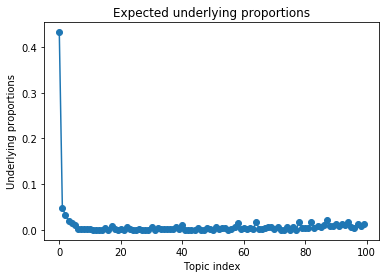

Discovered 13 significant topics at threshold 200.00


,topic 0: prob 0.43,topic 1: prob 0.05,topic 2: prob 0.03,topic 3: prob 0.02,topic 4: prob 0.01,topic 5: prob 0.01,topic 6: prob 0.00,topic 7: prob 0.00,topic 8: prob 0.00,topic 9: prob 0.00,topic 10: prob 0.00,topic 13: prob 0.00,topic 17: prob 0.01
0,"(new, 9980.1)","(japan, 1668.2)","(new, 564.9)","(march, 2413.2)","(goals, 2137.6)","(population, 471.5)","(score, 9852.1)","(john, 412.9)","(team, 570.1)","(ship, 669.5)","(district, 468.8)","(election, 280.9)","(week, 529.0)"
1,"(first, 8301.4)","(live, 1197.7)","(university, 559.8)","(gen, 1561.7)","(years, 1688.3)","(town, 302.9)","(team, 3933.6)","(sir, 277.1)","(score, 462.5)","(ships, 146.0)","(population, 315.9)","(results, 255.4)","(color, 324.2)"
2,"(two, 6036.8)","(action, 1018.1)","(first, 481.5)","(regiment, 1296.8)","(clubs, 1601.4)","(district, 253.6)","(seed, 2640.8)","(william, 218.1)","(seed, 244.4)","(station, 129.7)","(county, 306.6)","(general, 253.2)","(oct, 28.1)"
3,"(school, 4807.5)","(new, 644.3)","(research, 477.1)","(colonel, 1283.2)","(team, 1515.2)","(area, 248.5)","(goals, 486.7)","(lord, 173.1)","(round, 221.1)","(service, 79.2)","(province, 277.3)","(size, 228.9)","(san, 19.5)"
4,"(county, 4792.6)","(song, 586.6)","(social, 396.6)","(league, 1001.7)","(league, 1144.0)","(age, 229.5)","(attendance, 381.8)","(charles, 163.5)","(first, 175.5)","(navy, 64.5)","(village, 257.2)","(lead, 226.4)","(california, 15.9)"
5,"(time, 4597.5)","(best, 576.6)","(state, 385.7)","(infantry, 995.7)","(season, 1095.8)","(school, 219.2)","(report, 331.5)","(george, 163.0)","(season, 138.0)","(line, 61.2)","(rural, 247.9)","(con, 225.4)","(state, 14.8)"
6,"(american, 4515.2)","(music, 555.1)","(support, 381.5)","(volunteer, 931.5)","(club, 891.2)","(new, 199.0)","(round, 230.9)","(henry, 149.0)","(world, 134.1)","(fleet, 52.2)","(central, 132.0)","(green, 102.4)","(mens, 12.8)"
7,"(city, 4102.1)","(two, 552.3)","(based, 379.3)","(september, 885.3)","(cup, 842.9)","(village, 188.4)","(result, 207.4)","(hall, 115.7)","(mens, 127.9)","(class, 44.6)","(poland, 118.7)","(nov, 44.5)","(santa, 10.9)"
8,"(year, 4013.1)","(released, 513.1)","(national, 367.1)","(october, 871.4)","(played, 686.5)","(state, 185.0)","(won, 165.2)","(son, 115.2)","(won, 124.1)","(railway, 40.2)","(elevation, 97.3)","(oct, 41.8)","(george, 10.5)"
9,"(years, 3984.3)","(name, 476.3)","(states, 350.0)","(season, 864.0)","(first, 638.3)","(island, 183.2)","(points, 145.0)","(duke, 114.3)","(event, 111.0)","(march, 38.4)","(south, 95.2)","(feb, 40.0)","(davis, 9.7)"


In [39]:
vocabfile = "dictnostops.txt"
file = {}
file["lambda"] ="results/thdpK100_D20_wiki10k_wiki1k/lambda-800.dat"
file["a"] ="results/thdpK100_D20_wiki10k_wiki1k/a-800.dat"
file["b"] ="results/thdpK100_D20_wiki10k_wiki1k/b-800.dat"
normalized = False
method = "thdp"
threshold = 200
displaycount = 10
df = printtopics(vocabfile, file, method, normalized, threshold, displaycount)
df

### T_HDP with topic ordering, corrected E-step, ran for a small number of mini-batches

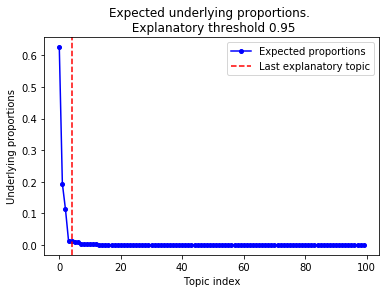

Discovered 7 significant topics at dirichlet threshold 200.00


,"0: prob 0.63, mean 2778.50","1: prob 0.19, mean 1932.63","2: prob 0.11, mean 964.27","3: prob 0.01, mean 248.76","7: prob 0.00, mean 611.06","8: prob 0.00, mean 49.01","13: prob 0.00, mean 298.15"
0,"(new, 4563.7)","(first, 2311.6)","(road, 1950.1)","(score, 1535.7)","(score, 2967.2)","(bridge, 207.7)","(week, 1151.4)"
1,"(first, 3694.5)","(season, 2275.8)","(town, 1349.7)","(team, 471.5)","(team, 1473.4)","(aux, 103.9)","(color, 650.5)"
2,"(american, 3014.6)","(team, 2158.4)","(county, 1318.1)","(cells, 129.9)","(seed, 1239.3)","(avenue, 47.1)","(con, 315.6)"
3,"(university, 2630.7)","(goals, 2123.5)","(district, 955.4)","(cell, 59.7)","(round, 150.7)","(nelson, 37.3)","(lead, 286.9)"
4,"(state, 2537.8)","(years, 2052.6)","(line, 951.1)","(seed, 56.3)","(van, 76.0)","(trail, 31.3)","(results, 178.2)"
5,"(two, 2294.5)","(year, 2029.2)","(street, 931.4)","(attitude, 54.9)","(first, 63.1)","(lake, 14.5)","(election, 156.5)"
6,"(city, 2289.5)","(series, 1761.8)","(species, 616.6)","(birds, 48.8)","(second, 38.8)","(rail, 12.7)","(nov, 97.4)"
7,"(states, 2269.3)","(two, 1708.6)","(south, 546.2)","(theory, 48.7)","(mark, 38.7)","(local, 12.7)","(oct, 75.1)"
8,"(march, 2251.8)","(game, 1497.0)","(east, 513.2)","(league, 41.4)","(fall, 31.9)","(city, 12.0)","(feb, 35.7)"
9,"(time, 2238.6)","(played, 1407.8)","(river, 510.9)","(two, 40.7)","(clay, 31.5)","(chicago, 10.9)","(california, 34.2)"


In [73]:
vocabfile = "dictnostops.txt"
file = {}
file["lambda"] ="results/thdpK100_T20_D50_wiki10k_wiki1k/lambda-100.dat"
file["a"] ="results/thdpK100_T20_D50_wiki10k_wiki1k/a-100.dat"
file["b"] ="results/thdpK100_T20_D50_wiki10k_wiki1k/b-100.dat"
method = "thdp"
dirthresh = 200
probthresh = 0.95
displaycount = 10
df = printtopics(vocabfile, file, method, dirthresh, probthresh, displaycount)
df

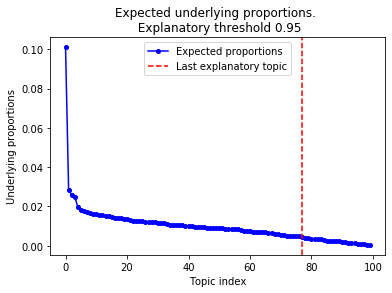

Discovered 18 significant topics at dirichlet threshold 200.00


,"0: prob 0.10, mean 2993.21","2: prob 0.03, mean 1118.33","8: prob 0.02, mean 64.12","9: prob 0.02, mean 1579.73","41: prob 0.01, mean 110.98","59: prob 0.01, mean 1231.24","66: prob 0.01, mean 509.70","73: prob 0.00, mean 85.37","76: prob 0.00, mean 572.60","77: prob 0.00, mean 147.41","83: prob 0.00, mean 345.42","85: prob 0.00, mean 328.40","88: prob 0.00, mean 703.94","92: prob 0.00, mean 222.74","93: prob 0.00, mean 419.12","95: prob 0.00, mean 1380.35","97: prob 0.00, mean 189.12","99: prob 0.00, mean 127.90"
0,"(first, 5086.8)","(japan, 1799.9)","(color, 400.6)","(team, 2383.2)","(moore, 449.5)","(march, 2543.1)","(jewish, 680.4)","(ship, 598.2)","(county, 1441.2)","(genus, 464.3)","(line, 672.7)","(age, 540.7)","(goals, 1849.8)","(district, 489.7)","(data, 1084.3)","(score, 7706.2)","(new, 604.3)","(fat, 412.8)"
1,"(new, 4980.1)","(new, 1665.5)","(oath, 43.0)","(first, 2371.7)","(genus, 346.5)","(gen, 1745.1)","(american, 640.6)","(notes, 33.7)","(lake, 1330.3)","(species, 338.2)","(road, 491.7)","(population, 482.3)","(attendance, 833.1)","(county, 344.0)","(sort, 1003.2)","(team, 3111.8)","(york, 345.2)","(studio, 209.4)"
2,"(two, 3622.4)","(live, 1342.8)","(east, 32.6)","(season, 1754.8)","(butler, 82.8)","(colonel, 1381.4)","(university, 629.6)","(service, 33.1)","(road, 462.6)","(family, 215.4)","(station, 453.6)","(county, 425.7)","(team, 802.8)","(province, 278.0)","(value, 921.9)","(seed, 1932.3)","(railroad, 191.1)","(single, 146.8)"
3,"(time, 2964.4)","(action, 1116.5)","(liberal, 28.2)","(league, 1548.3)","(species, 66.3)","(regiment, 1378.9)","(new, 557.6)","(navy, 31.0)","(south, 383.7)","(found, 105.8)","(school, 447.6)","(city, 310.5)","(report, 733.9)","(rural, 240.7)","(neat, 280.9)","(round, 315.0)","(chicago, 152.9)","(best, 116.7)"
4,"(years, 2378.9)","(year, 1051.6)","(june, 26.3)","(cup, 1532.2)","(family, 37.5)","(volunteer, 1075.6)","(jews, 557.6)","(ships, 29.0)","(north, 372.3)","(described, 98.8)","(street, 272.3)","(years, 270.5)","(years, 697.7)","(village, 234.2)","(team, 205.1)","(draw, 206.0)","(pennsylvania, 130.9)","(released, 80.4)"
5,"(state, 2317.2)","(music, 906.4)","(first, 22.7)","(years, 1326.0)","(martin, 37.0)","(infantry, 1014.8)","(first, 504.8)","(boat, 28.2)","(new, 368.9)","(distant, 73.4)","(new, 261.4)","(present, 268.7)","(clubs, 684.4)","(population, 175.3)","(october, 153.7)","(first, 135.8)","(express, 120.6)","(music, 79.8)"
6,"(school, 2195.0)","(two, 834.0)","(november, 22.5)","(year, 1273.5)","(sharp, 24.8)","(april, 820.3)","(party, 414.2)","(class, 27.2)","(river, 361.2)","(marine, 62.8)","(railway, 248.5)","(living, 255.6)","(result, 486.9)","(central, 147.0)","(solid, 144.9)","(hard, 103.6)","(central, 100.7)","(year, 79.8)"
7,"(city, 2173.6)","(best, 831.0)","(board, 22.5)","(new, 1237.0)","(valley, 24.7)","(october, 819.5)","(school, 404.9)","(clay, 25.3)","(town, 346.9)","(tribe, 39.3)","(high, 243.5)","(average, 250.3)","(score, 385.1)","(poland, 142.5)","(points, 144.3)","(second, 98.5)","(railway, 92.5)","(female, 55.7)"
8,"(university, 2137.6)","(american, 827.8)","(taking, 22.4)","(two, 1193.1)","(wood, 22.0)","(july, 782.3)","(states, 377.6)","(crew, 24.0)","(east, 333.8)","(south, 38.3)","(city, 193.9)","(town, 247.4)","(league, 301.6)","(north, 89.9)","(rank, 128.9)","(clay, 97.3)","(pacific, 78.4)","(love, 49.9)"
9,"(united, 2076.1)","(world, 807.8)","(council, 20.4)","(world, 1177.5)","(east, 18.7)","(september, 751.4)","(united, 329.7)","(beam, 24.0)","(area, 325.1)","(new, 37.8)","(north, 169.0)","(income, 232.3)","(club, 264.1)","(east, 86.1)","(size, 124.0)","(van, 97.0)","(limited, 74.6)","(performance, 47.7)"


In [74]:
vocabfile = "dictnostops.txt"
file = {}
file["lambda"] ="results/thdpK100_T20_D50_wiki10k_wiki1k/lambda-500.dat"
file["a"] ="results/thdpK100_T20_D50_wiki10k_wiki1k/a-500.dat"
file["b"] ="results/thdpK100_T20_D50_wiki10k_wiki1k/b-500.dat"
method = "thdp"
dirthresh = 400
probthresh = 0.95
displaycount = 10
df = printtopics(vocabfile, file, method, dirthresh, probthresh, displaycount)
df

### N_HDP, corrected E-step, small number of mini-batches 

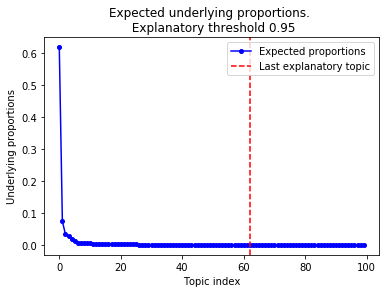

Discovered 6 significant topics at dirichlet threshold 200.00


,"0: prob 0.62, mean 3615.52","1: prob 0.07, mean 338.55","2: prob 0.03, mean 479.00","3: prob 0.03, mean 1189.84","5: prob 0.01, mean 101.64","13: prob 0.00, mean 217.47"
0,"(first, 5774.8)","(year, 708.4)","(county, 956.3)","(score, 5222.2)","(female, 233.6)","(week, 1329.3)"
1,"(new, 5721.5)","(race, 341.6)","(road, 799.4)","(team, 2955.3)","(species, 152.7)","(color, 533.9)"
2,"(two, 3991.8)","(top, 337.7)","(town, 767.8)","(seed, 1337.8)","(favorite, 107.9)","(match, 122.7)"
3,"(time, 3283.6)","(finished, 318.2)","(population, 502.4)","(attendance, 522.7)","(love, 102.2)","(state, 34.6)"
4,"(years, 3243.3)","(army, 315.7)","(district, 460.1)","(report, 388.3)","(top, 82.1)","(mask, 32.6)"
5,"(american, 2928.4)","(july, 298.6)","(village, 306.4)","(result, 344.0)","(best, 77.2)","(san, 27.7)"
6,"(state, 2908.2)","(left, 294.0)","(bridge, 300.8)","(match, 308.5)","(genus, 69.9)","(first, 25.7)"
7,"(university, 2868.1)","(international, 268.5)","(age, 266.3)","(goals, 289.9)","(format, 66.4)","(california, 24.9)"
8,"(school, 2800.6)","(board, 257.5)","(rural, 228.4)","(round, 273.8)","(year, 63.3)","(santa, 22.6)"
9,"(world, 2634.9)","(american, 245.3)","(meeting, 202.1)","(final, 255.9)","(chapter, 61.1)","(man, 20.7)"


In [76]:
vocabfile = "dictnostops.txt"
file = {}
file["lambda"] ="results/nhdpK100_T20_D50_wiki10k_wiki1k/lambda-100.dat"
file["a"] ="results/nhdpK100_T20_D50_wiki10k_wiki1k/a-100.dat"
file["b"] ="results/nhdpK100_T20_D50_wiki10k_wiki1k/b-100.dat"
method = "nhdp"
probthresh = 0.95
dirthresh = 200
displaycount = 10
df = printtopics(vocabfile, file, method, dirthresh, probthresh, displaycount)
df

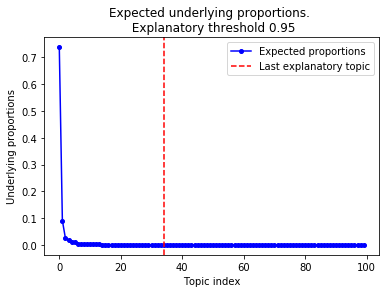

Discovered 6 significant topics at dirichlet threshold 200.00


,"0: prob 0.74, mean 6763.38","1: prob 0.09, mean 624.93","2: prob 0.03, mean 627.35","3: prob 0.02, mean 1670.52","7: prob 0.00, mean 73.21","13: prob 0.00, mean 40.96"
0,"(new, 11339.9)","(value, 1131.9)","(county, 1672.5)","(score, 8181.2)","(alexander, 242.9)","(week, 239.2)"
1,"(first, 10585.0)","(data, 1123.0)","(lake, 1170.1)","(team, 3620.3)","(race, 146.2)","(color, 107.8)"
2,"(two, 7321.4)","(sort, 1005.4)","(district, 684.3)","(seed, 2028.6)","(archbishop, 123.7)","(dos, 15.8)"
3,"(years, 6551.1)","(october, 729.8)","(population, 642.4)","(goals, 716.7)","(lap, 108.3)","(match, 14.7)"
4,"(time, 6023.2)","(september, 683.1)","(village, 464.8)","(attendance, 567.0)","(driver, 29.4)","(state, 6.2)"
5,"(march, 5592.9)","(august, 356.8)","(road, 389.9)","(report, 562.7)","(pope, 21.6)","(mexico, 5.9)"
6,"(year, 5217.2)","(mount, 333.5)","(rural, 368.7)","(round, 365.7)","(ten, 18.5)","(san, 5.8)"
7,"(school, 5023.2)","(concept, 317.3)","(province, 334.2)","(result, 358.0)","(motor, 16.6)","(california, 5.8)"
8,"(united, 4997.3)","(neat, 311.4)","(age, 321.8)","(first, 155.0)","(engine, 13.8)","(santa, 4.3)"
9,"(american, 4982.6)","(december, 257.1)","(sign, 224.8)","(won, 150.0)","(private, 11.1)","(mask, 4.1)"


In [75]:
vocabfile = "dictnostops.txt"
file = {}
file["lambda"] ="results/nhdpK100_T20_D50_wiki10k_wiki1k/lambda-500.dat"
file["a"] ="results/nhdpK100_T20_D50_wiki10k_wiki1k/a-500.dat"
file["b"] ="results/nhdpK100_T20_D50_wiki10k_wiki1k/b-500.dat"
method = "nhdp"
probthresh = 0.95
dirthresh = 200
displaycount = 10
df = printtopics(vocabfile, file, method, dirthresh, probthresh, displaycount)
df

# Warm-start

## Train LDA 1/K using SB-LDA topics

In [27]:
def lda_warm(K, Dlist, inroot, heldoutroot, topicpath, expset, ax, plot_error, plot_cold):
    """
    Inputs:
        K: approximation level
        Dlist: batch sizes; should always contain only positive numbers
        inroot: "wiki10k"
        heldoutroot: "wiki1k"
        topicpath: "results/sbldaK100_D16_wiki10k_wiki1k/lambda-300", for instance
        expset: dictionary of experimental seeds, keys being minibatch sizes in Dlist
        ax: axis to plot
        plot_error: whether to plot error bars
        plot_cold: whether to plot a representative cold-start training 
    Outputs:
        plots warm-start LDA 1/K's LL (vs number of training examples) for the different 
        minibatch sizes in Dlist. For context, also plot cold-start LL. 
    """
    
    exs = {} # number of training examples processed; 
    exs[0] = 0 # exs[0] keep track of maximum number of training examples ever-processed across batch sizes
    avg = {} # average LL 
    err = {} # standard deviation in LL
    
    # warm-start results
    for i in range(len(Dlist)):
        D = Dlist[i]
        seeds = expset[D]
        dirname = "results/ldaK" + str(K) + "_" + "D" + str(D) + "_" + inroot + "_" + heldoutroot \
                    + "/warm/" + topicpath
        LL = []
        for seed in seeds:
            path = dirname + "/LL_" + str(seed) + ".csv"
            result = np.loadtxt(path)
            batchcounts = result[:,0]
            LL.append(result[:,2])
        batchcounts = np.array(batchcounts)
        exs[D] = D*batchcounts
        exs[0] = max(exs[0],max(exs[D]))
        LL = np.array(LL) # shape len(expset) x len(batchcounts)
        avg[D] = np.mean(LL, axis=0) # shape (len(batchcounts),)
        err[D] = np.std(LL, axis=0) # shape (len(batchcounts),)
    for i in range(len(Dlist)):
        D = Dlist[i]
        if (plot_error):
            ax.errorbar(exs[D], avg[D], yerr=err[D],label='D = %d' %D)
        else:
            ax.plot(exs[D], avg[D], label='D = %d' %D)
    
    if (plot_cold):
        # representative cold-start
        dirname = "results/ldaK" + str(K) + "_" + "D" + str(Dlist[-1]) + "_" + inroot + "_" + heldoutroot
        LL = []
        seeds = expset[Dlist[-1]]
        for seed in seeds:
            path = dirname + "/LL_" + str(seed) + ".csv"
            result = np.loadtxt(path)
            batchcounts = result[:,0]
            LL.append(result[:,2])
        batchcounts = np.array(batchcounts)
        cold_exs = D*batchcounts
        LL = np.array(LL) # shape len(expset) x len(batchcounts)
        cold_avg = np.mean(LL, axis=0) # shape (len(batchcounts),)
        cold_err = np.std(LL, axis=0) # shape (len(batchcounts),)
        ## find the right range of training examples to plot both cold and warm results
        indices = cold_exs <= exs[0]

        if (plot_error):
            ax.errorbar(cold_exs[indices], cold_avg[indices], yerr=cold_err[indices], \
                        linestyle='--',label='cold, D = %d' %Dlist[-1])
        else:
            ax.plot(cold_exs[indices], cold_avg[indices], linestyle='--', \
                    label='cold, D = %d' %Dlist[-1])
    
    ax.set_title('LDA 1/K, K = %d \n %s' %(K,topicpath))
    ax.set_xlabel('Number of training examples processed')
    ax.set_ylabel('Held-out log-likelihood')
    ax.legend()
    return

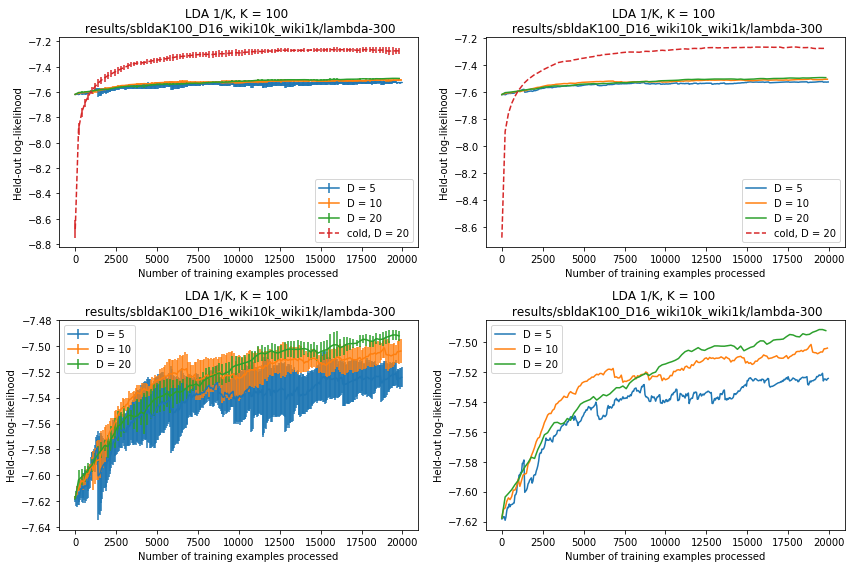

In [28]:
K = 100
Dlist = [5, 10, 20]
inroot = "wiki10k"
heldoutroot = "wiki1k"
topicpath = "results/sbldaK100_D16_wiki10k_wiki1k/lambda-300"
expset = {5:[0,1,2,3,4], 10:[0,1,2,3,4], 20:[0,1,2,3,4]}

fig, axes = plt.subplots(2,2,figsize=(12,8))
lda_warm(K, Dlist, inroot, heldoutroot, topicpath, expset, axes[0,0], True, True)
lda_warm(K, Dlist, inroot, heldoutroot, topicpath, expset, axes[0,1], False, True)
lda_warm(K, Dlist, inroot, heldoutroot, topicpath, expset, axes[1,0], True, False)
lda_warm(K, Dlist, inroot, heldoutroot, topicpath, expset, axes[1,1], False, False)
plt.tight_layout()
plt.show()

## Train SB-LDA using LDA 1/K topics

In [ ]:
def sblda_warm(K, Dlist, inroot, heldoutroot, topicpath, expset, ax, plot_error, plot_cold):
    """
    Inputs:
        K: approximation level
        Dlist: batch sizes; should always contain only positive numbers
        inroot: "wiki10k"
        heldoutroot: "wiki1k"
        topicpath: "results/sbldaK100_D16_wiki10k_wiki1k/lambda-300", for instance
        expset: dictionary of experimental seeds, keys being minibatch sizes in Dlist
        ax: axis to plot
        plot_error: whether to plot error bars
        plot_cold: whether to plot a representative cold-start training 
    Outputs:
        plots warm-start SB-LDA 1/K's LL (vs number of training examples) for the different 
        minibatch sizes in Dlist. For context, also plot cold-start LL. 
    """
    
    exs = {} # number of training examples processed; 
    exs[0] = 0 # exs[0] keep track of maximum number of training examples ever-processed across batch sizes
    avg = {} # average LL 
    err = {} # standard deviation in LL
    
    # warm-start results
    for i in range(len(Dlist)):
        D = Dlist[i]
        seeds = expset[D]
        dirname = "results/sbldaK" + str(K) + "_" + "D" + str(D) + "_" + inroot + "_" + heldoutroot \
                    + "/warm/" + topicpath
        LL = []
        for seed in seeds:
            path = dirname + "/LL_" + str(seed) + ".csv"
            result = np.loadtxt(path)
            batchcounts = result[:,0]
            LL.append(result[:,2])
        batchcounts = np.array(batchcounts)
        exs[D] = D*batchcounts
        exs[0] = max(exs[0],max(exs[D]))
        LL = np.array(LL) # shape len(expset) x len(batchcounts)
        avg[D] = np.mean(LL, axis=0) # shape (len(batchcounts),)
        err[D] = np.std(LL, axis=0) # shape (len(batchcounts),)
    for i in range(len(Dlist)):
        D = Dlist[i]
        if (plot_error):
            ax.errorbar(exs[D], avg[D], yerr=err[D],label='D = %d' %D)
        else:
            ax.plot(exs[D], avg[D], label='D = %d' %D)
    
    if (plot_cold):
        # representative cold-start
        dirname = "results/sbldaK" + str(K) + "_" + "D" + str(Dlist[-1]) + "_" + inroot + "_" + heldoutroot
        LL = []
        seeds = expset[Dlist[-1]]
        for seed in seeds:
            path = dirname + "/LL_" + str(seed) + ".csv"
            result = np.loadtxt(path)
            batchcounts = result[:,0]
            LL.append(result[:,2])
        batchcounts = np.array(batchcounts)
        cold_exs = D*batchcounts
        LL = np.array(LL) # shape len(expset) x len(batchcounts)
        cold_avg = np.mean(LL, axis=0) # shape (len(batchcounts),)
        cold_err = np.std(LL, axis=0) # shape (len(batchcounts),)
        ## find the right range of training examples to plot both cold and warm results
        indices = cold_exs <= exs[0]

        if (plot_error):
            ax.errorbar(cold_exs[indices], cold_avg[indices], yerr=cold_err[indices], \
                        linestyle='--',label='cold, D = %d' %Dlist[-1])
        else:
            ax.plot(cold_exs[indices], cold_avg[indices], linestyle='--', \
                    label='cold, D = %d' %Dlist[-1])
    
    ax.set_title('SB-LDA, K = %d \n %s' %(K,topicpath))
    ax.set_xlabel('Number of training examples processed')
    ax.set_ylabel('Held-out log-likelihood')
    ax.legend()
    return